In [209]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

%pylab inline
%matplotlib inline

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift
from sklearn.preprocessing import StandardScaler

import gensim.downloader as api

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors, Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

from tqdm import tqdm

from scipy.spatial import distance

Populating the interactive namespace from numpy and matplotlib


In [2]:
#load models, number refers to dimensions
model_wikipedia200 = api.load("glove-wiki-gigaword-200")

2022-03-10 16:29:35,227 : INFO : loading projection weights from /Users/kate/gensim-data/glove-wiki-gigaword-200/glove-wiki-gigaword-200.gz
2022-03-10 16:30:10,931 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (400000, 200) matrix of type float32 from /Users/kate/gensim-data/glove-wiki-gigaword-200/glove-wiki-gigaword-200.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-03-10T16:30:10.931118', 'gensim': '4.0.1', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:37) \n[Clang 11.1.0 ]', 'platform': 'macOS-12.2.1-x86_64-i386-64bit', 'event': 'load_word2vec_format'}


In [3]:
model_twitter200 = api.load("glove-twitter-200")

2022-03-10 16:30:11,161 : INFO : loading projection weights from /Users/kate/gensim-data/glove-twitter-200/glove-twitter-200.gz
2022-03-10 16:31:59,376 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (1193514, 200) matrix of type float32 from /Users/kate/gensim-data/glove-twitter-200/glove-twitter-200.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-03-10T16:31:59.372862', 'gensim': '4.0.1', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:37) \n[Clang 11.1.0 ]', 'platform': 'macOS-12.2.1-x86_64-i386-64bit', 'event': 'load_word2vec_format'}


In [225]:
model_wikipedia50 = api.load("glove-wiki-gigaword-50")

2022-03-11 01:15:51,532 : INFO : loading projection weights from /Users/kate/gensim-data/glove-wiki-gigaword-50/glove-wiki-gigaword-50.gz
2022-03-11 01:16:01,948 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (400000, 50) matrix of type float32 from /Users/kate/gensim-data/glove-wiki-gigaword-50/glove-wiki-gigaword-50.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-03-11T01:16:01.947683', 'gensim': '4.0.1', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:37) \n[Clang 11.1.0 ]', 'platform': 'macOS-12.2.1-x86_64-i386-64bit', 'event': 'load_word2vec_format'}


In [226]:
model_twitter25 = api.load("glove-twitter-25")

2022-03-11 01:16:03,012 : INFO : loading projection weights from /Users/kate/gensim-data/glove-twitter-25/glove-twitter-25.gz
2022-03-11 01:16:22,050 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (1193514, 25) matrix of type float32 from /Users/kate/gensim-data/glove-twitter-25/glove-twitter-25.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-03-11T01:16:22.050399', 'gensim': '4.0.1', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:37) \n[Clang 11.1.0 ]', 'platform': 'macOS-12.2.1-x86_64-i386-64bit', 'event': 'load_word2vec_format'}


In [227]:
#compare 10 closest vectors to any word
model_wikipedia50.most_similar('girl')

[('boy', 0.9327197670936584),
 ('woman', 0.906528115272522),
 ('mother', 0.8347674012184143),
 ('girls', 0.8182200789451599),
 ('girlfriend', 0.8109234571456909),
 ('teenage', 0.8099073767662048),
 ('her', 0.808667778968811),
 ('teen', 0.8006073236465454),
 ('baby', 0.7916797399520874),
 ('man', 0.7907536029815674)]

In [228]:
model_wikipedia200.most_similar('girl')

[('boy', 0.8486549854278564),
 ('girls', 0.7696278691291809),
 ('woman', 0.7648226022720337),
 ('child', 0.7002282738685608),
 ('mother', 0.6969297528266907),
 ('teenage', 0.6899838447570801),
 ('boys', 0.6887997388839722),
 ('teen', 0.6872598528862),
 ('teenager', 0.6842571496963501),
 ('daughter', 0.6838234663009644)]

In [229]:
model_twitter200.most_similar('girl')

[('boy', 0.8434211015701294),
 ('girls', 0.8288909792900085),
 ('she', 0.8030763864517212),
 ('guy', 0.7873061299324036),
 ('woman', 0.7817050218582153),
 ('chick', 0.7750226855278015),
 ('friend', 0.7702169418334961),
 ('bitch', 0.7611055374145508),
 ('that', 0.7493616342544556),
 ('pretty', 0.746584951877594)]

In [230]:
model_twitter25.most_similar('girl')

[('boy', 0.9596140384674072),
 ('kid', 0.9532699584960938),
 ('like', 0.9455346465110779),
 ('guy', 0.9448168873786926),
 ('friend', 0.941986620426178),
 ('look', 0.939540684223175),
 ('sister', 0.9377638697624207),
 ('boyfriend', 0.9370700716972351),
 ('she', 0.9360417723655701),
 ('girls', 0.9336651563644409)]

In [233]:
#analogy test: man is to king as woman is to ___.
result = model_twitter25.most_similar(positive=['woman', 'king'], negative=['man'], topn=3)
print(result)

[('meets', 0.8841923475265503), ('prince', 0.832163393497467), ('queen', 0.8257461190223694)]


In [234]:
result = model_twitter200.most_similar(positive=['woman', 'king'], negative=['man'], topn=3)
print(result)

[('queen', 0.6820898056030273), ('prince', 0.5875527262687683), ('princess', 0.5620488524436951)]


In [235]:
result = model_wikipedia200.most_similar(positive=['woman', 'king'], negative=['man'], topn=3)
print(result)

[('queen', 0.6978679299354553), ('princess', 0.6081744432449341), ('monarch', 0.5889754891395569)]


In [236]:
result = model_wikipedia50.most_similar(positive=['woman', 'king'], negative=['man'], topn=3)
print(result)

[('queen', 0.8523604273796082), ('throne', 0.7664334177970886), ('prince', 0.7592144012451172)]


In [4]:
plt.rcParams['figure.figsize'] = [6,6]
sns.set_style("whitegrid")
sns.set_context("talk")

In [5]:
# helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X,km=[],num_clusters=10):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

In [6]:
X = model_wikipedia200.vectors

In [308]:
X

array([[-2.50328585, -3.1382643 ],
       [-2.35231146, -1.47697014],
       [-3.23415337, -3.23413696],
       ...,
       [ 6.35144821,  7.07015024],
       [ 5.97347874,  5.11812535],
       [ 5.83693304,  5.25509736]])

IndexError: string index out of range

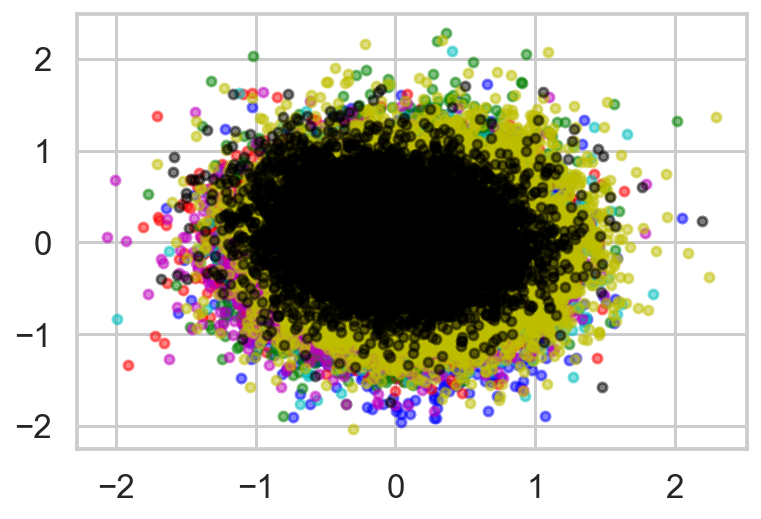

In [389]:
num_clusters = 10
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1) # n_init, number of times the K-mean algorithm will run
km.fit(X)
display_cluster(X,km,num_clusters)

In [390]:
km.inertia_

9949642.0

In [210]:
inertia = []
for n_clusters in tqdm(range(2,60,2)):
    km = KMeans(n_clusters=n_clusters)
    km.fit(X)
    inertia.append(km.inertia_)
    

100%|███████████████████████████████████████████| 29/29 [01:25<00:00,  2.96s/it]


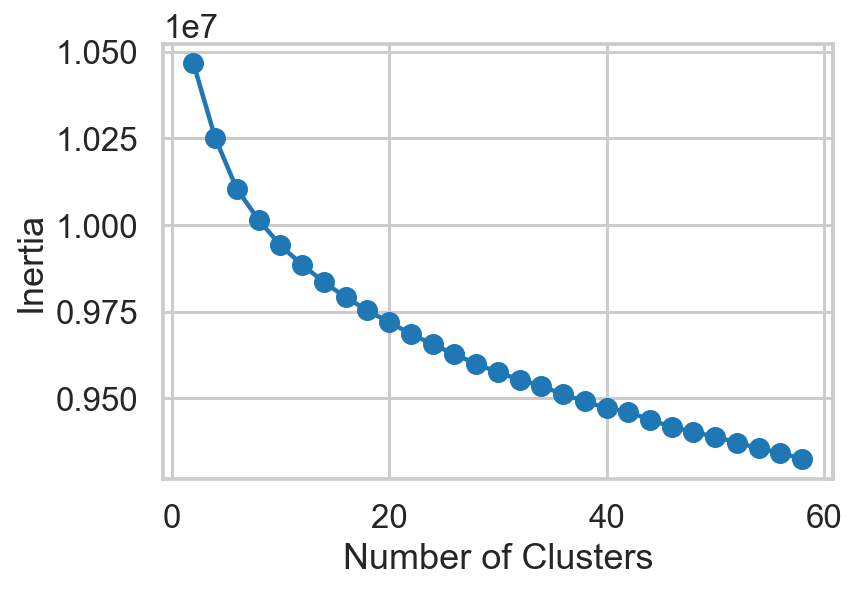

In [398]:
plt.plot(range(2,60,2),    inertia)
plt.scatter(range(2,60,2), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

IndexError: string index out of range

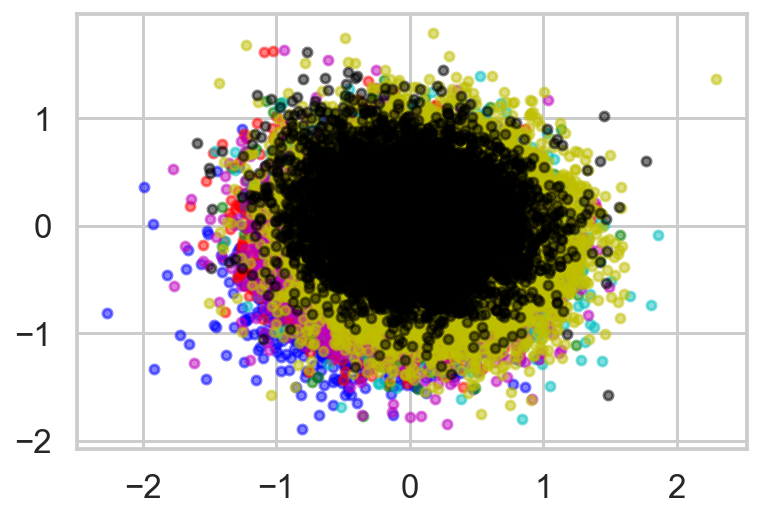

In [406]:
num_clusters = 20
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1) # n_init, number of times the K-mean algorithm will run
km.fit(X)
display_cluster(X, km, 20)

In [54]:
vectors = model_wikipedia200.vectors
vectors.shape

(400000, 200)

In [211]:
words = []
for i in tqdm(range(400000)):
    words.append(model_wikipedia200.index_to_key[i])
# words

100%|██████████████████████████████| 400000/400000 [00:00<00:00, 1484262.79it/s]


In [25]:
# uncomment to save wikipedia words as .txt

# with open('wikipedia_words.txt', 'w') as f:
#     for item in words:
#         f.write("%s\n" % item)

In [378]:
len(model_wikipedia200.vectors)

400000

In [9]:
# Cluster each vectorized document 
kmeans = KMeans(n_clusters=10)
kmeans.fit(model_wikipedia200.vectors);


In [212]:
df = pd.DataFrame({
    "text": ["".join(text) for text in words],
    "cluster": kmeans.labels_
})
# df

In [213]:
wiki_clusters = df.groupby('cluster')['text'].apply(list).to_dict()
# wiki_clusters

In [12]:
#twitter model
Y = model_twitter200.vectors
num_clusters = 20
km_t = KMeans(n_clusters=20,random_state=1,n_init=1) # n_init, number of times the K-mean algorithm will run
km_t.fit(Y)
# display_cluster(Y,km_t,num_clusters)

KMeans(n_clusters=20, n_init=1, random_state=1)

In [418]:
model_twitter200.vectors.shape

(1193514, 200)

In [214]:
twitter_words = []
for i in tqdm(range(1193514)):
    twitter_words.append(model_twitter200.index_to_key[i])
# twitter_words

100%|████████████████████████████| 1193514/1193514 [00:00<00:00, 1340510.42it/s]


In [215]:
df_twitter = pd.DataFrame({
    "text": ["".join(text) for text in twitter_words],
    "cluster": km_t.labels_
})
# df_twitter

In [216]:
twitter_clusters = df_twitter.groupby('cluster')['text'].apply(list).to_dict()
# twitter_clusters

In [421]:
inertia_t = []
for n_clusters in tqdm(range(2,60,2)):
    km = KMeans(n_clusters=n_clusters)
    km.fit(X)
    inertia_t.append(km.inertia_)

100%|████████████████████████████████████████| 29/29 [5:33:23<00:00, 689.78s/it]


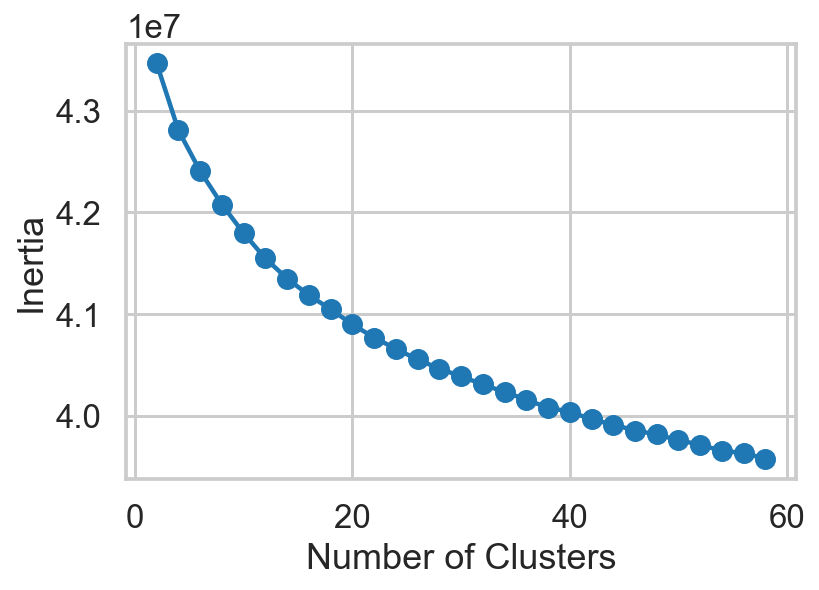

In [422]:
plt.plot(range(2,60,2),    inertia_t)
plt.scatter(range(2,60,2), inertia_t)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

In [ ]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
#     plt.xlim(-25, 25)
#     plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [ ]:
import os

base_path = "/Users/kate/Downloads/"
filename = "twitter_words.txt"
path_to_file = os.path.join(base_path, filename)
fd = open(path_to_file , 'r')

In [217]:
twitter_set = set(line.strip() for line in open('/Users/kate/Downloads/twitter_words.txt'))

# twitter_set

In [218]:
wikipedia_set = set(words)
# wikipedia_set

In [219]:
common_words = twitter_set & wikipedia_set 
print(len(common_words))
# list(common_words)

14424


In [31]:
# with open('common_words.txt', 'w') as f:
#     for item in common_words:
#         f.write("%s\n" % item)

In [220]:
wiki_indices = []
twitter_indices = []
for word in tqdm(common_words):
    wiki_indices.append(model_wikipedia200.key_to_index[word])
    twitter_indices.append(model_twitter200.key_to_index[word])
# wiki_indices

100%|██████████████████████████████████| 14424/14424 [00:00<00:00, 41394.50it/s]


In [18]:
wiki_vecs = []
twitter_vecs = []
for i in wiki_indices:
    wiki_vecs.append(model_wikipedia200[i])
    
for j in twitter_indices:
    twitter_vecs.append(model_twitter200[j])

len(twitter_vecs)

14424

In [22]:
X = wiki_vecs
X = np.array(X)

In [20]:
def plot_X_and_proj(X, X_proj):
    '''
    Plot data matrix X against its projection onto principal components
    '''
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    fig.tight_layout()

    ax[0].scatter(X[:,0], X[:,1], c='b')
    ax[0].set_title('Original Data X')
    
    ax[1].scatter(X_proj[:,0], X_proj[:,1], c='r')
    ax[1].set_title('X Projected Onto Principal Components')

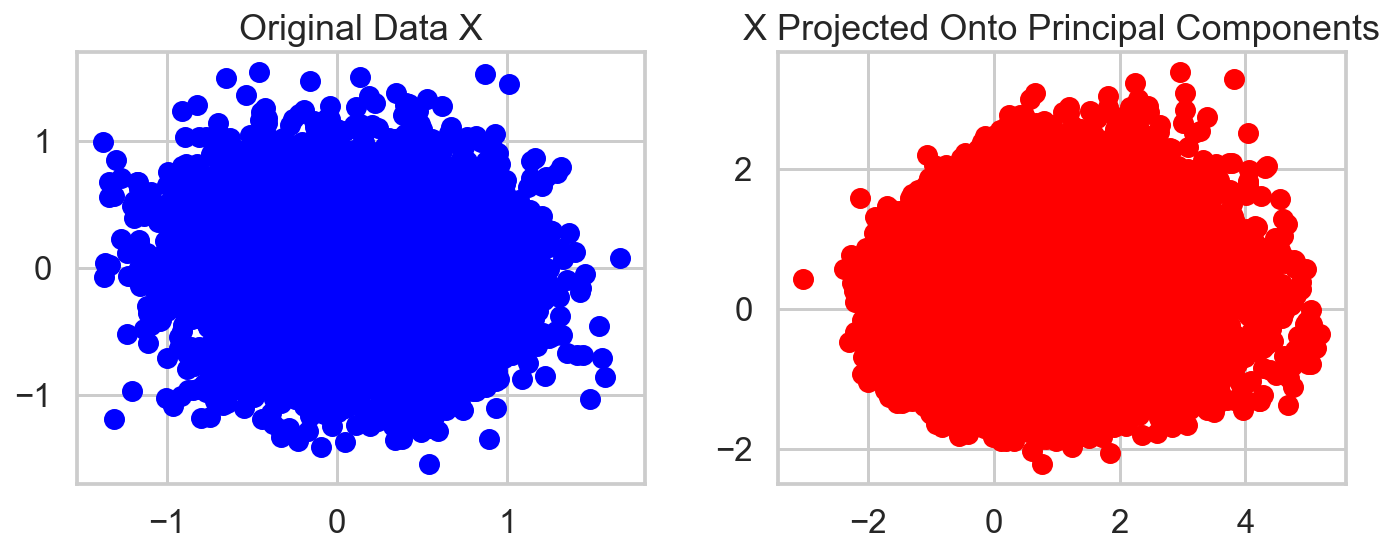

In [86]:
#X is wikipedia, Y is twitter
from sklearn.decomposition import PCA
X = np.array(wiki_vecs)
pca = PCA(100)
X_proj = pca.fit_transform(X)
plot_X_and_proj(X, X_proj)

In [87]:
def show_variance_explained_plots(pca):
    
    var_exp_array = pca.explained_variance_ratio_
    n_comps = var_exp_array.shape[0] 
    
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    
    ax[0].fill_between(range(n_comps), var_exp_array)
    ax[0].set_title('Variance Explained by Nth Principal Component')
    
    ax[1].fill_between(range(n_comps), np.cumsum(var_exp_array))
    ax[1].set_title('Cumulative Variance Explained by N Components')
    
    plt.show()

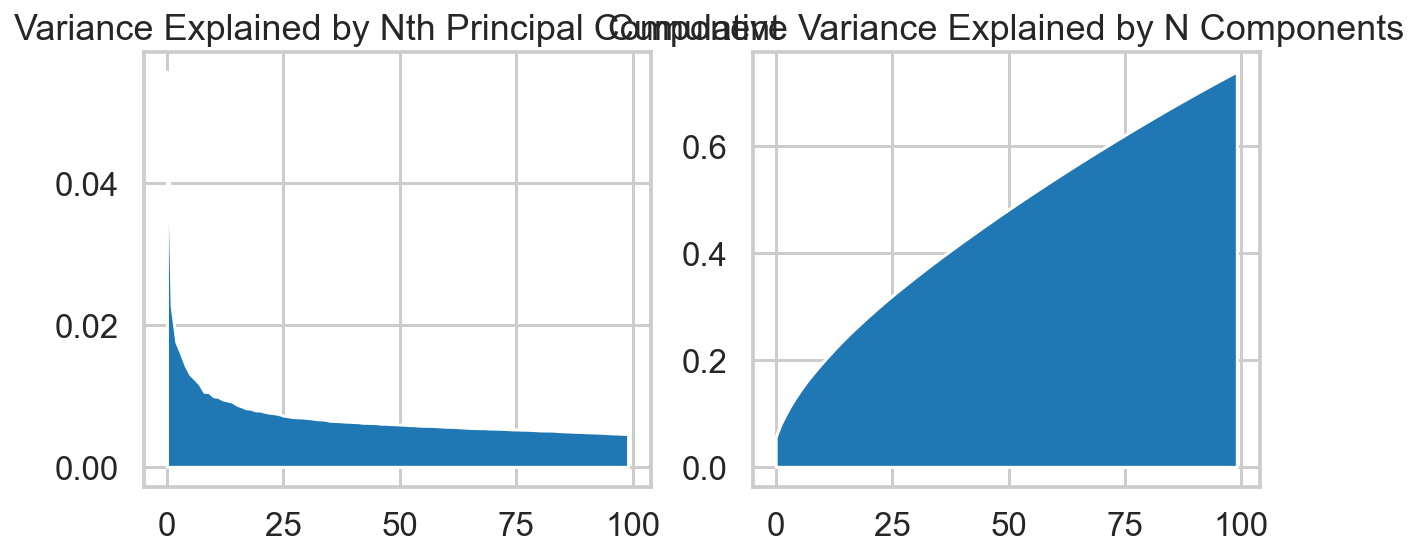

In [88]:
show_variance_explained_plots(pca)

In [168]:

# Standardize our data for DBSCAN and fit DBSCAN
X_proj = StandardScaler().fit_transform(X_proj)
db = DBSCAN(eps=.4, min_samples=10, metric='cosine').fit(X_proj)

# find the observations DBSCAN called "core"
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels_w = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_w)) - (1 if -1 in labels_w else 0)
n_clusters_

14

In [98]:
n_clusters_

35

2022-03-10 17:40:29,360 : WARNING : *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
2022-03-10 17:40:29,373 : WARNING : *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
2022-03-10 17:40:29,379 : WARNING : *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you in

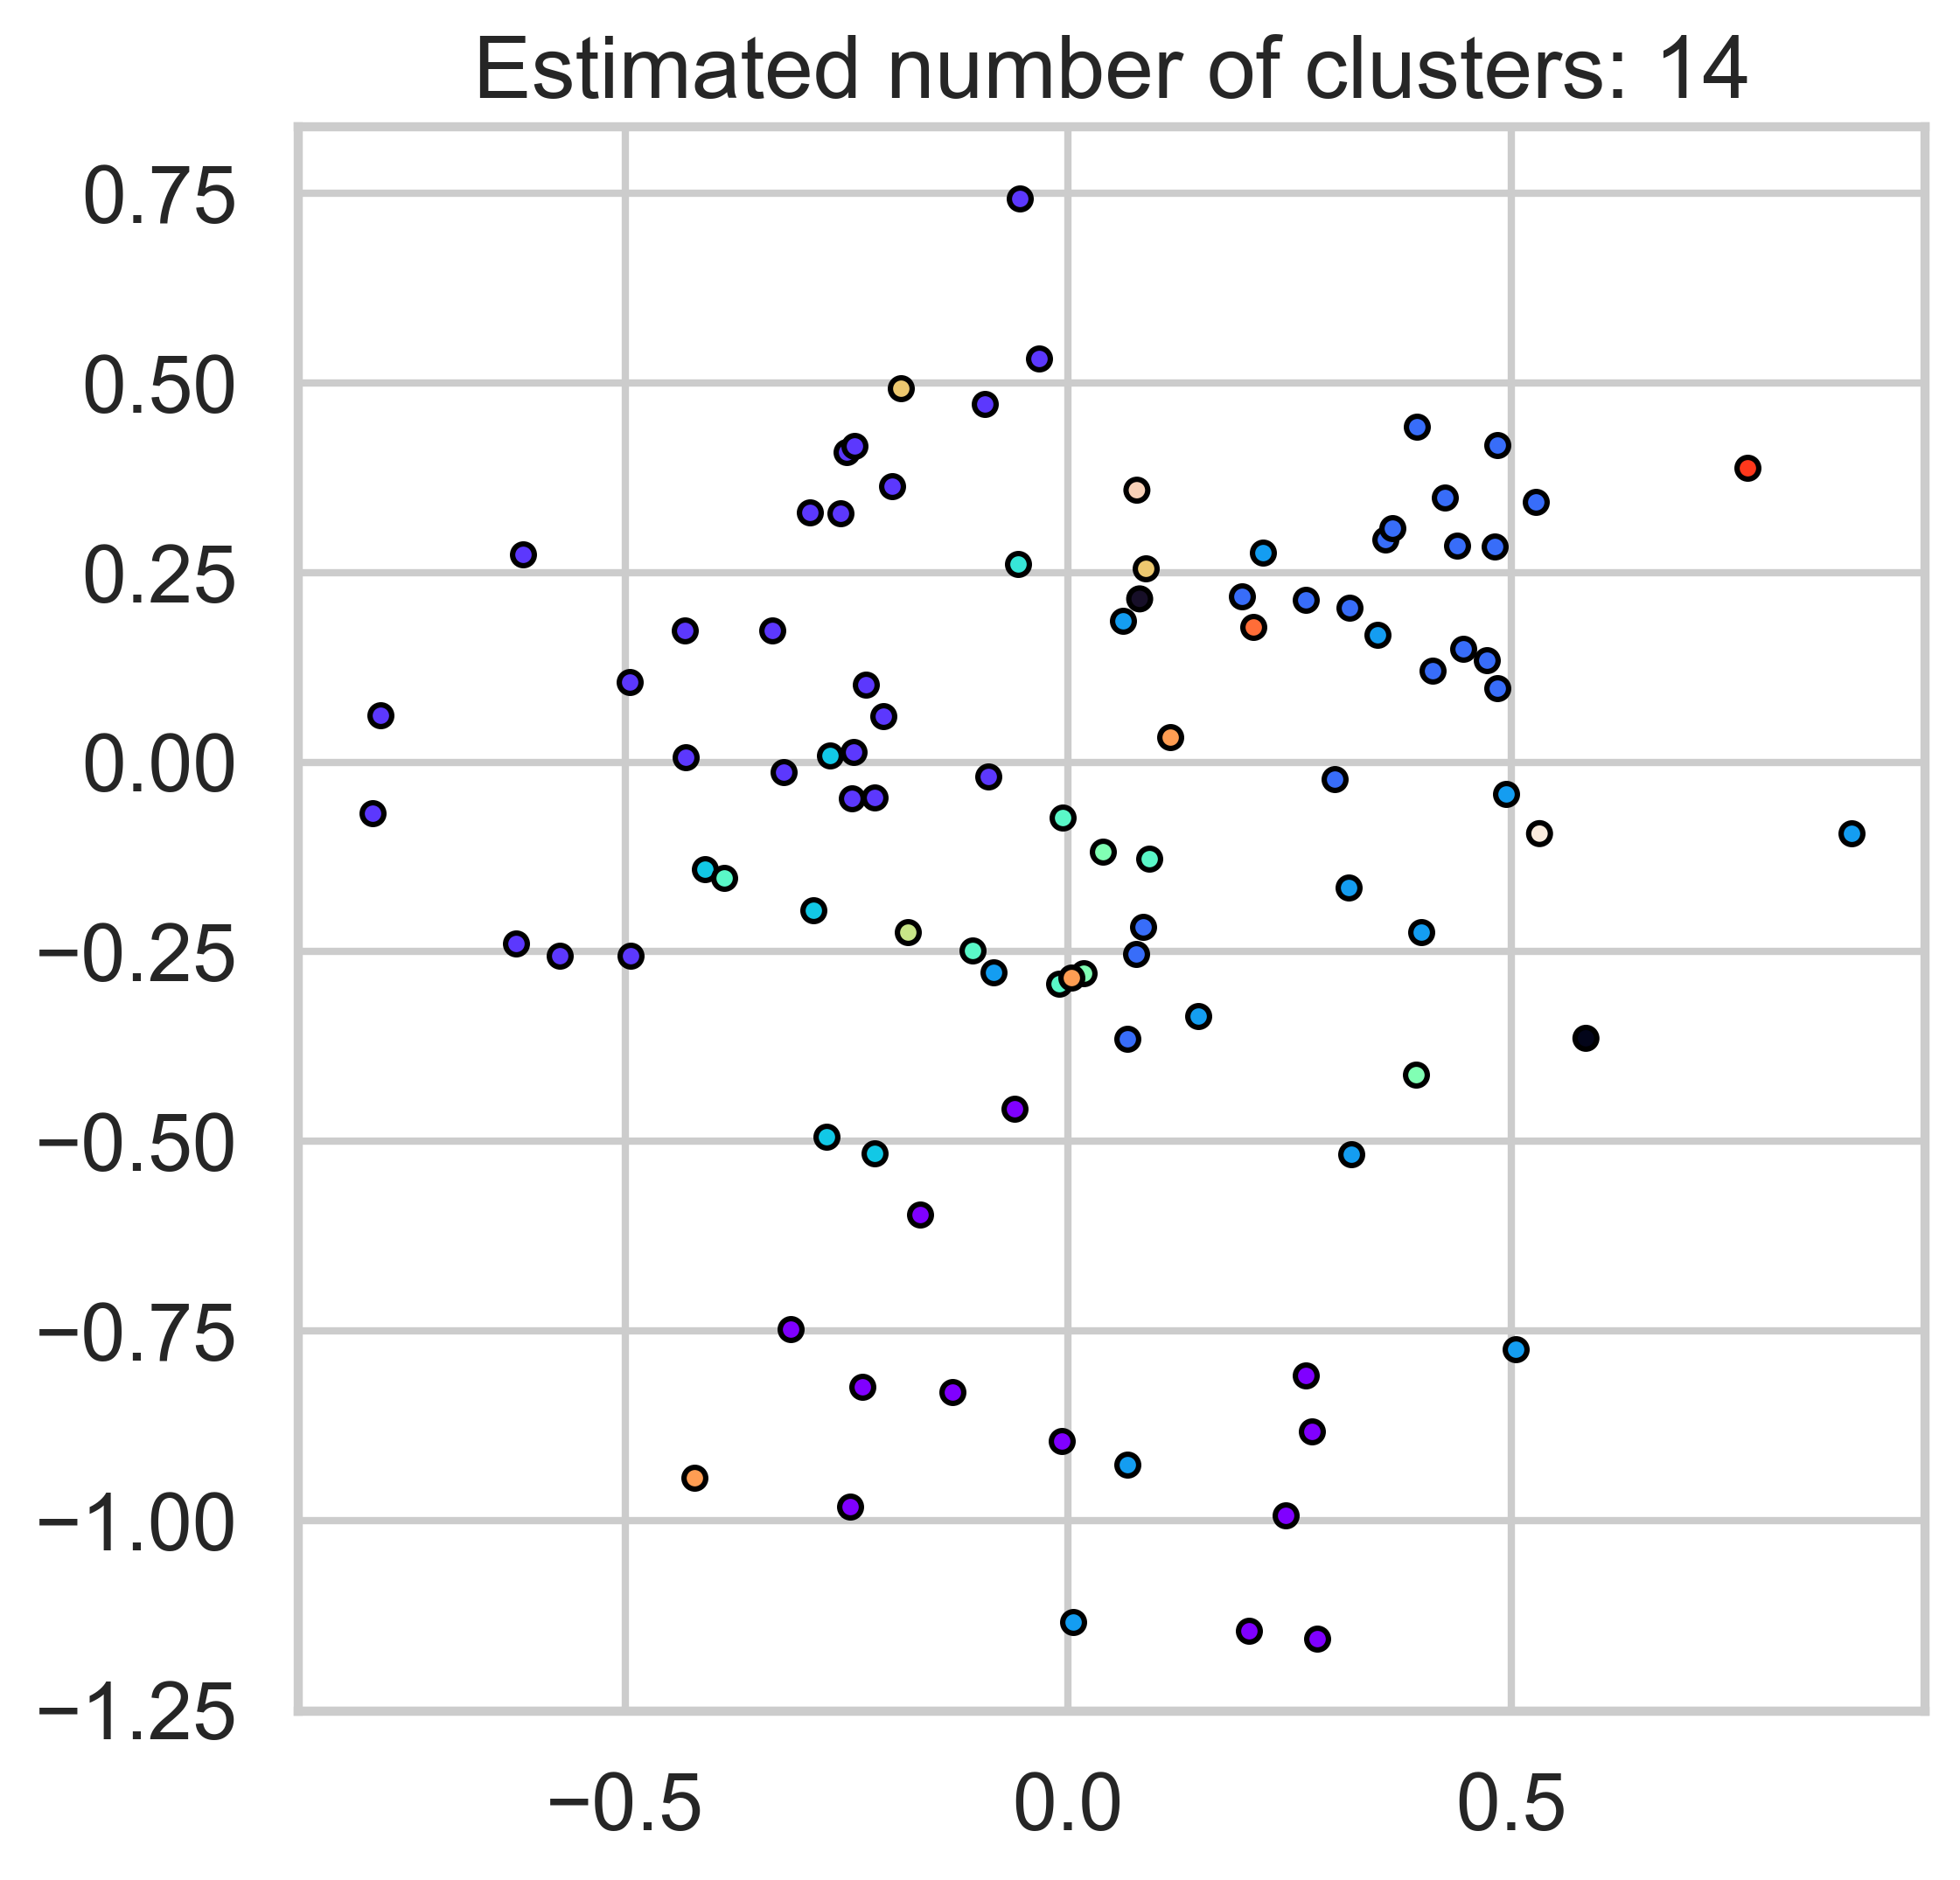

In [169]:
unique_labels = set(labels_w)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
plt.figure(dpi=200)
show_core = True
show_non_core = False
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels_w == k)
    if show_core:
        xy = X[class_member_mask & core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, edgecolors='k',  s=20, linewidths=1.1) # add black border for core points
    
    if show_non_core:
        xy = X[class_member_mask & ~core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, s=20, linewidths=1.1)

plt.title('Estimated number of clusters: %d' % n_clusters_);



In [119]:
cluster = []
for i in range(len(list(labels_w))):
    if list(labels_w)[i] in(-1.0,0):
        pass
    else:
        cluster.append(list(labels_w)[i])
    
word_column = []
for i in db.core_sample_indices_:
    word_column.append(list(common_words)[i])

9

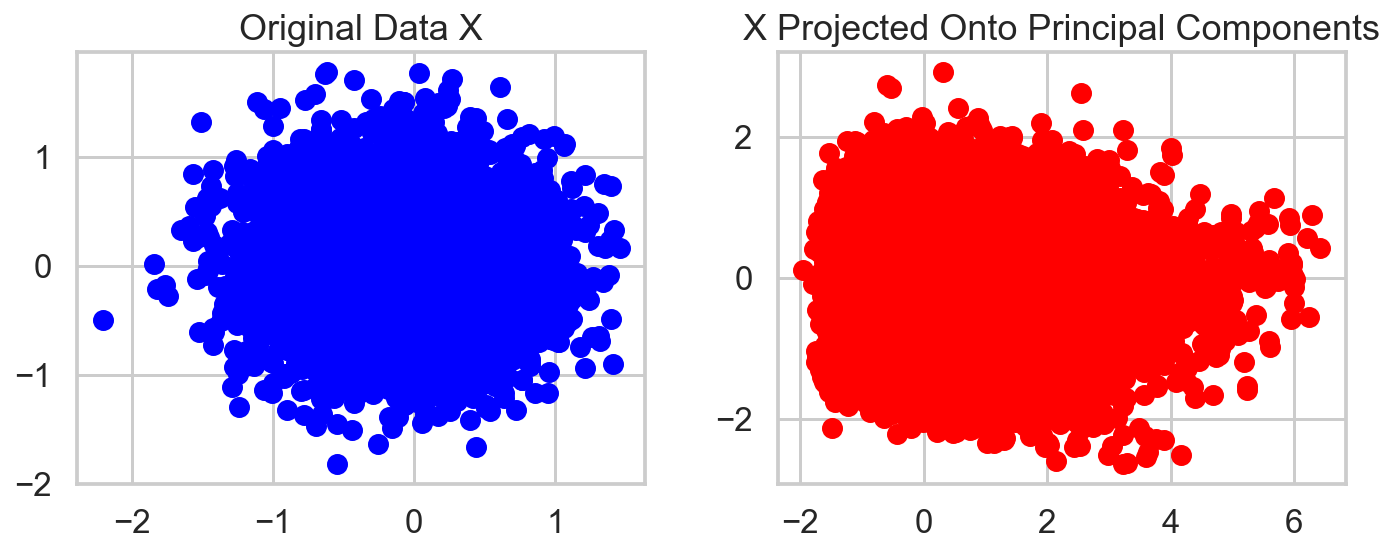

In [121]:
#twitter
Y = twitter_vecs
Y = np.array(Y)

pca = PCA(125)
Y_proj = pca.fit_transform(Y)
plot_X_and_proj(Y, Y_proj)

# Standardize our data for DBSCAN and fit DBSCAN
Y_proj = StandardScaler().fit_transform(Y_proj)
db = DBSCAN(eps=.6, min_samples=7, metric='cosine').fit(Y_proj)

# Let's find the observations DBSCAN called "core"
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

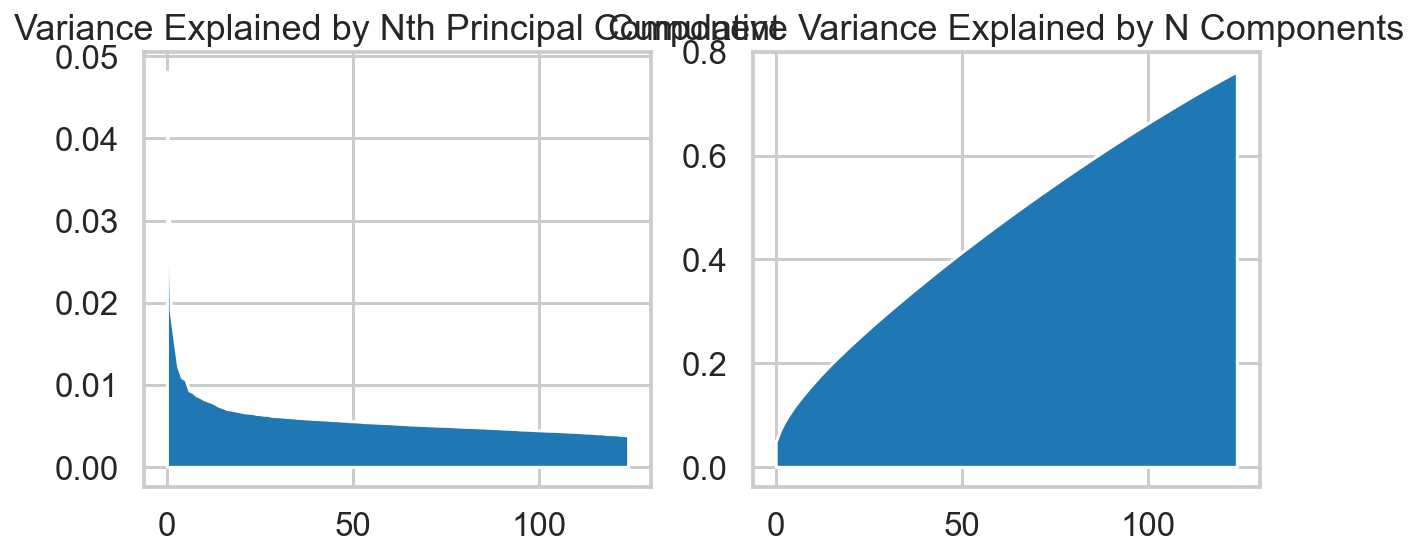

In [63]:
show_variance_explained_plots(pca)

2022-03-10 17:11:52,186 : WARNING : *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
2022-03-10 17:11:52,189 : WARNING : *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
2022-03-10 17:11:52,192 : WARNING : *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you in

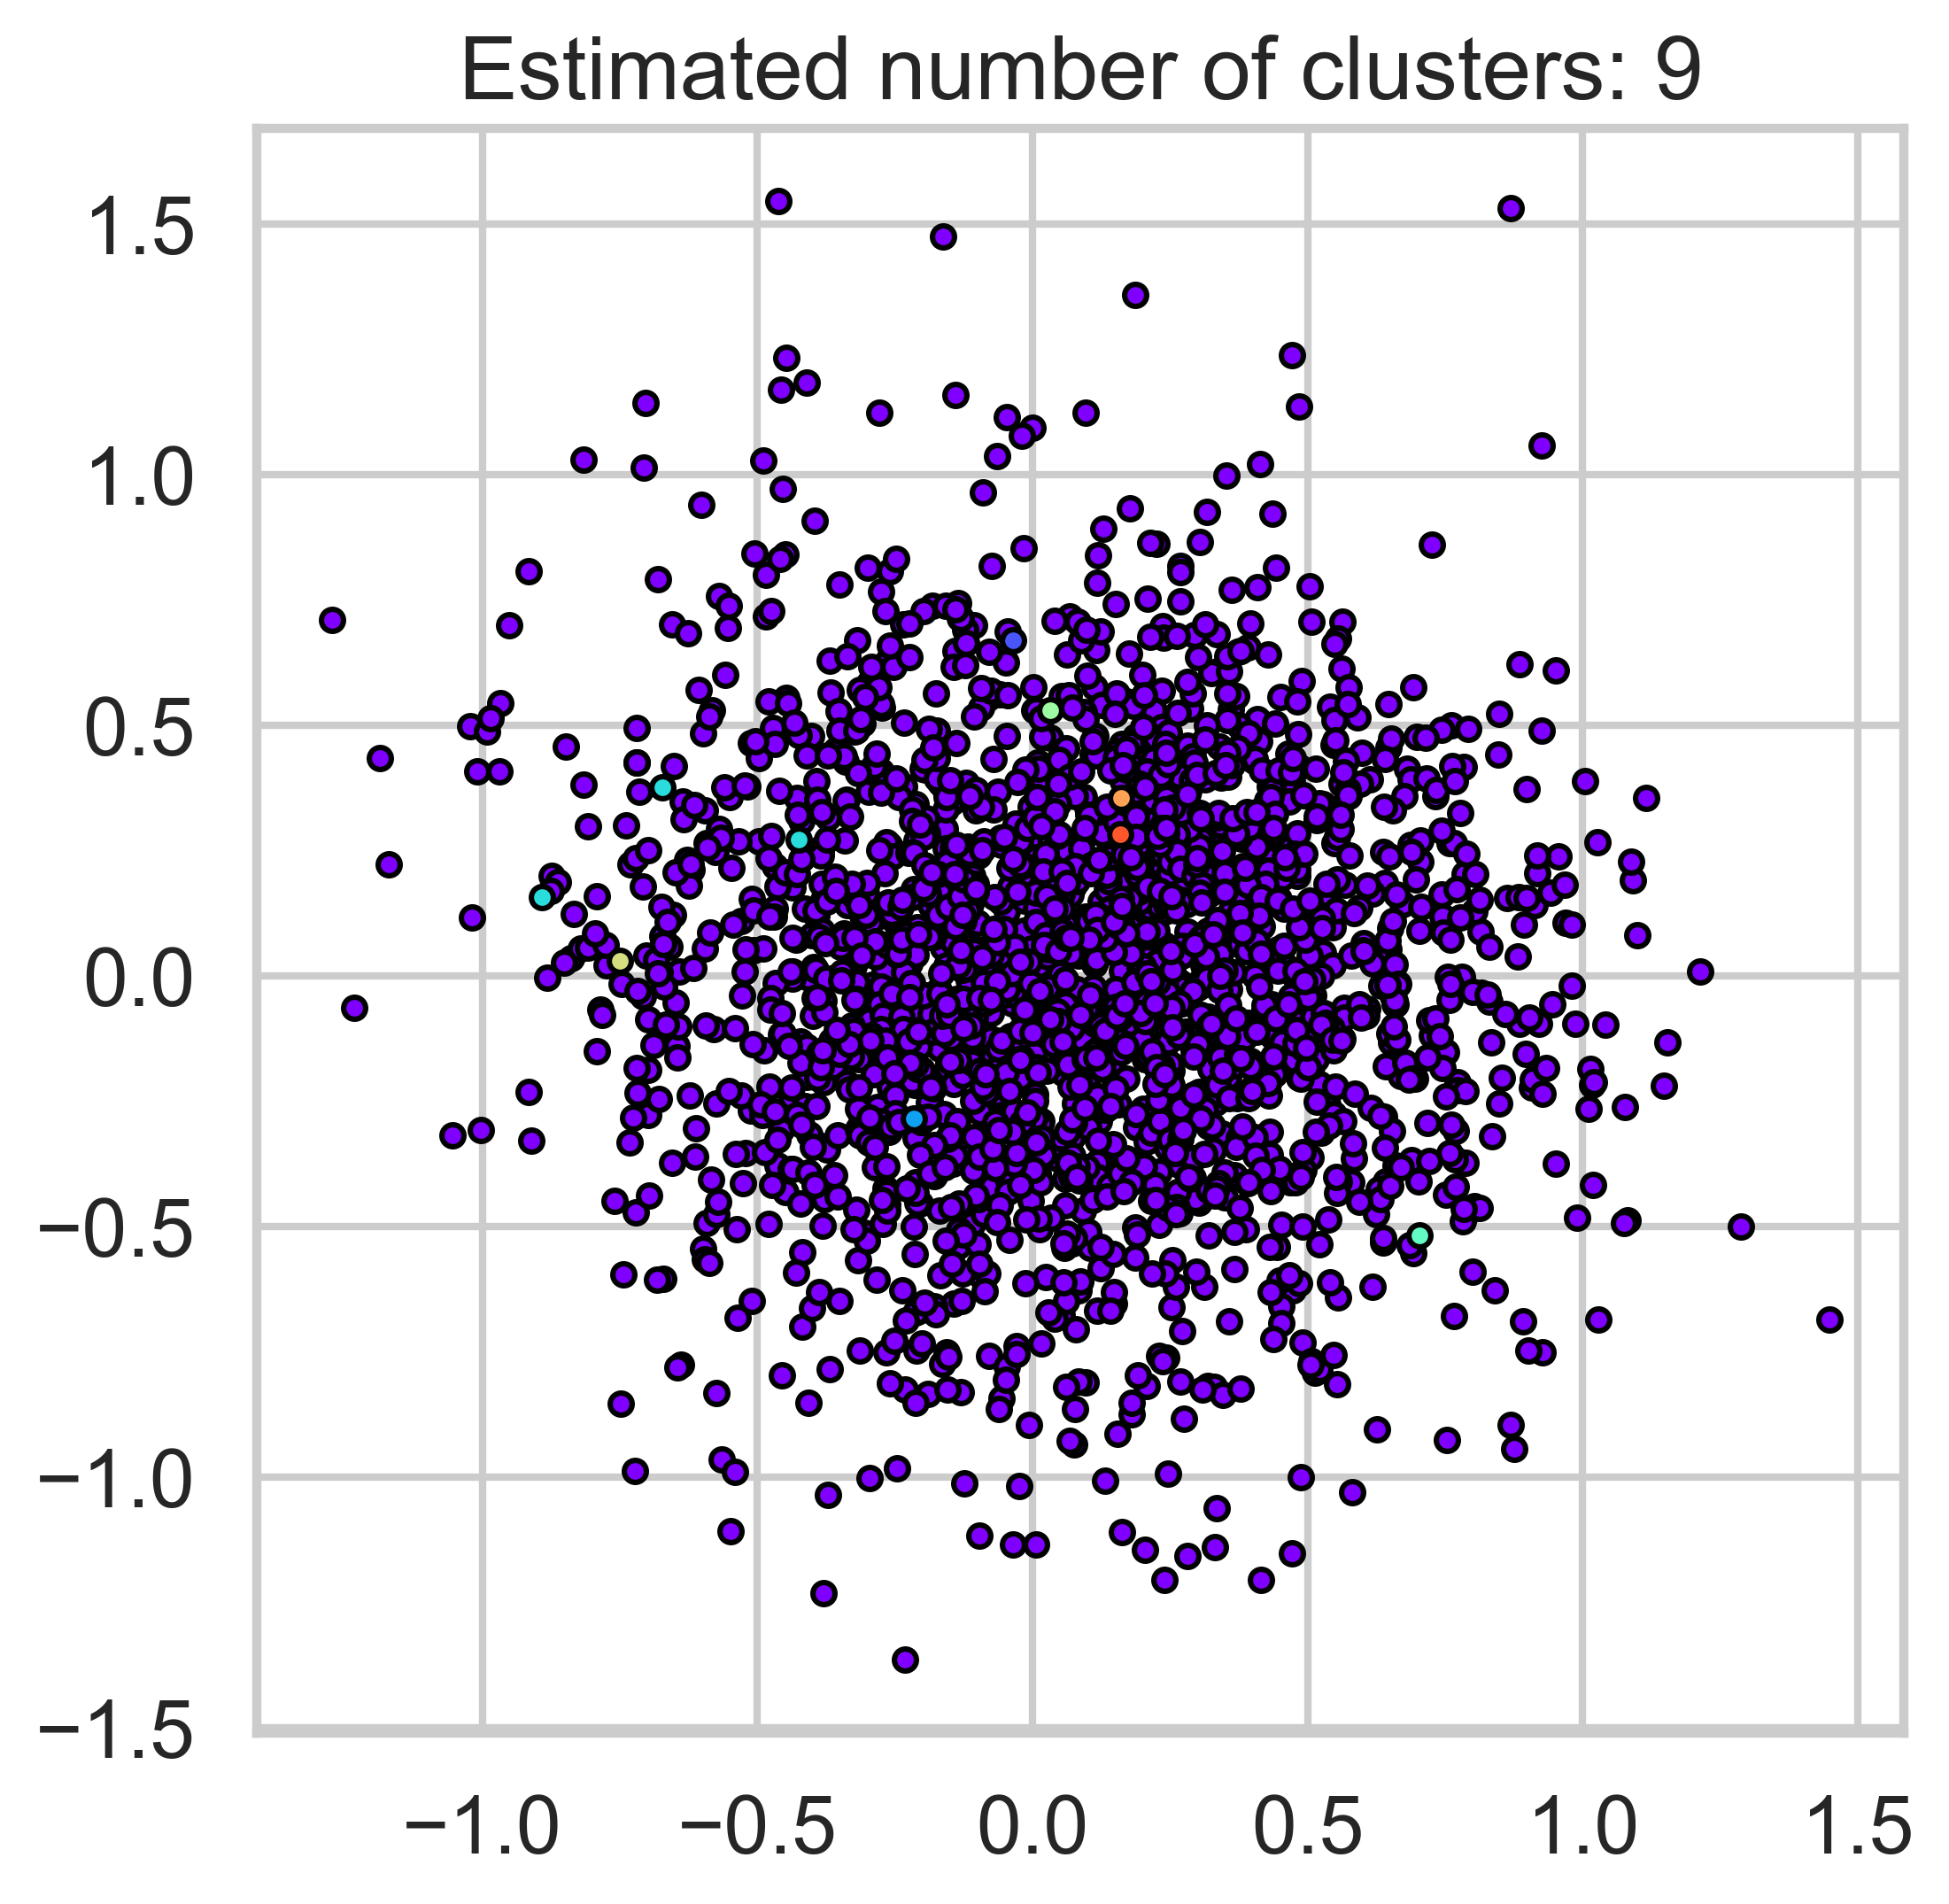

In [122]:
unique_labels = set(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
plt.figure(dpi=200)
show_core = True
show_non_core = False
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)
    if show_core:
        xy = X[class_member_mask & core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, edgecolors='k',  s=20, linewidths=1.1) # add black border for core points
    
    if show_non_core:
        xy = X[class_member_mask & ~core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, s=20, linewidths=1.1)

plt.title('Estimated number of clusters: %d' % n_clusters_);


In [123]:
from sklearn import metrics
print("Twitter Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Y, labels))

print("Wikipedia Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels_w))

Twitter Silhouette Coefficient: -0.073
Wikipedia Silhouette Coefficient: -0.112


In [133]:
cluster = []
for i in range(len(list(db.labels_))):
    if list(db.labels_)[i] in (-1,0):
        pass
    else:
        cluster.append(list(db.labels_)[i])
#         print(db.labels_[i])
    
word_column = []
for i in db.core_sample_indices_:
    word_column.append(list(common_words)[i])
    


In [221]:
cluster0 = np.nonzero(labels == 0)[0]
cluster1 = np.nonzero(labels == 1)[0]
cluster2 = np.nonzero(labels == 2)[0]
cluster3 = np.nonzero(labels == 3)[0]
cluster4 = np.nonzero(labels == 4)[0]
cluster5 = np.nonzero(labels == 5)[0]
cluster6 = np.nonzero(labels == 6)[0]
cluster7 = np.nonzero(labels == 7)[0]
cluster8 = np.nonzero(labels == 8)[0]
cluster9 = np.nonzero(labels == 9)[0]

# print(db.core_sample_indices_)

In [200]:
def get_words(cluster, x):

    cluster_words = []
    for i in cluster:
#     cluster1_words.append(Y_proj[i])
        cluster_words.append(list(common_words)[i])
    
    print(f"Cluster {x}:", cluster_words,'\n')

In [207]:
print('Twitter Clusters: \n')
get_words(cluster1,1)
get_words(cluster2,2)
get_words(cluster3,3)
get_words(cluster4,4)
get_words(cluster5,5)
get_words(cluster6,6)
get_words(cluster7,7)
get_words(cluster8,8)


Twitter Clusters: 

Cluster 1: ['politicking', 'trashing', 'butchering', 'archiving', 'fabricating', 'flaunting', 'cribbing'] 

Cluster 2: ['thirstiest', 'straightest', 'shortest', 'thickest', 'hippest', 'whitest', 'thinnest'] 

Cluster 3: ['induct', 'inducted', 'inducts', 'inducting', 'hof', 'inductions', 'induction', 'inductees', 'inductee'] 

Cluster 4: ['bookshelf', 'shelving', 'bookcase', 'bookcases', 'headboard', 'shelves', 'bookshelves'] 

Cluster 5: ['conservatively', 'creatively', 'rationally', 'maturely', 'rephrase'] 

Cluster 6: ['one-off', 'half-hour', 'two-night', 'one-hour', 'two-hour'] 

Cluster 7: ['whole-heartedly', 'wholehearted', 'heartedly', 'heartily', 'respectfully', 'wholeheartedly', 'wholly'] 

Cluster 8: ['orthodontics', 'orthodontists', 'osteopath', 'orthodontist'] 



In [196]:
def get_vectors(cluster, x):

    cluster_vectors = []
    for i in cluster:
        cluster_vectors.append(twitter_vecs[i])
    
    print(f"Cluster {x}:", np.mean(cluster_vectors[0],cluster_vectors[1],cluster_vectors[2]))

In [170]:
#wikipedia clusters
cluster0_w = np.nonzero(labels_w == 0)[0]
cluster1_w = np.nonzero(labels_w == 1)[0]
cluster2_w = np.nonzero(labels_w == 2)[0]
cluster3_w = np.nonzero(labels_w == 3)[0]
cluster4_w = np.nonzero(labels_w == 4)[0]
cluster5_w = np.nonzero(labels_w == 5)[0]
cluster6_w = np.nonzero(labels_w == 6)[0]
cluster7_w = np.nonzero(labels_w == 7)[0]
cluster8_w = np.nonzero(labels_w == 8)[0]
cluster9_w = np.nonzero(labels_w == 9)[0]
cluster10_w = np.nonzero(labels_w == 10)[0]
cluster11_w = np.nonzero(labels_w == 11)[0]
cluster12_w = np.nonzero(labels_w == 12)[0]
cluster13_w = np.nonzero(labels_w == 13)[0]

In [205]:
#wikipedia clusters
print('Wikipedia Clusters: \n')


get_words(cluster1_w,1)
get_words(cluster2_w,2)
get_words(cluster3_w,3)
get_words(cluster4_w,4)
get_words(cluster5_w,5)
get_words(cluster6_w,6)
get_words(cluster7_w,7)
get_words(cluster8_w,8)
get_words(cluster9_w,9)
get_words(cluster10_w,10)
get_words(cluster11_w,11)
get_words(cluster12_w,12)
get_words(cluster13_w,13)

Wikipedia Clusters: 

Cluster 1: ['twenty-six', 'seventy-five', 'thirty-five', 'forty-two', 'twenty-eight', 'twenty-nine', 'twenty-five', 'forty-five', 'four', 'thirteen', 'thirty-one', 'twenty-three', 'thirty-six', 'sixty-five', 'forty-six', 'sixty', 'three', 'forty', 'thirty', 'twenty-four', 'thirty-two', 'twenty-two', 'forty-eight', 'fourteen', 'sixty-four', 'thirty-three', 'twenty-one', 'thousand'] 

Cluster 2: ['exactly', 'really', 'surely', 'reason', 'importantly', 'though', 'actually', 'what', 'everything', 'fact', 'would', 'absolutely', 'thing', 'whoever', 'whatever', 'learned', 'although', 'somehow', 'think', 'this', 'things', 'ought', 'learn', 'undoubtedly', 'why', 'knew', 'everyone', 'might', 'know', 'thinks', 'nothing', 'certainly', 'hates', 'wherever', 'thought', 'whether', 'whenever', 'knowing', 'that', 'something', 'neither', 'thinking', 'clearly'] 

Cluster 3: ['warwickshire', 'northamptonshire', 'buckinghamshire', 'gloucestershire', 'monmouthshire', 'leicestershire', '

In [222]:
dists = []
for i in tqdm(range(len(list(common_words)))):
    dists.append(distance.cosine(twitter_vecs[i],wiki_vecs[i]))

100%|███████████████████████████████████| 14424/14424 [00:02<00:00, 6033.04it/s]


In [223]:
top_dists = np.argsort(dists)[:15]

In [224]:
for i in range(len(list(top_dists))):
    print(list(common_words)[i])

sparrow
fast-track
blithe
polly
throwin
sainthood
affirming
infancy
creamy
redistributing
fof
inflated
horace
indoctrinated
shuttleworth


IndexError: string index out of range

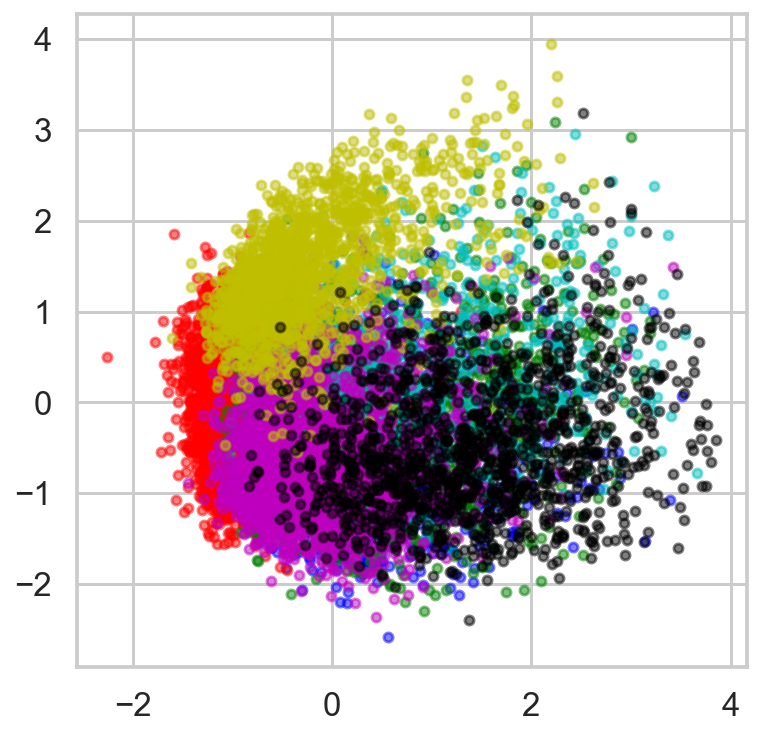

In [85]:
num_clusters = 10
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1) # n_init, number of times the K-mean algorithm will run
km.fit(X_proj)
display_cluster(X_proj,km,num_clusters)

In [238]:
#create interactive 3d graph of word embeddings

def append_list(sim_words, words):
    
    list_of_words = []
    
    for i in range(len(sim_words)):
        
        sim_words_list = list(sim_words[i])
        sim_words_list.append(words)
        sim_words_tuple = tuple(sim_words_list)
        list_of_words.append(sim_words_tuple)
        
    return list_of_words

input_word = 'twenty-six,exactly,warwickshire,fifth,indict,northwestern,forecasters'
user_input = [x.strip() for x in input_word.split(',')]
result_word = []
    
for words in user_input:
    
        sim_words = model_twitter200.most_similar(words, topn = 0)
        sim_words = append_list(sim_words, words)
            
        result_word.extend(sim_words)
    
similar_word = [word[0] for word in result_word]
similarity = [word[1] for word in result_word] 
similar_word.extend(user_input)
labels = [word[2] for word in result_word]
label_dict = dict([(y,x+1) for x,y in enumerate(set(labels))])
color_map = [label_dict[x] for x in labels]

In [239]:
import plotly.graph_objs as go
from sklearn.decomposition import PCA

def display_pca_scatterplot_3D(model=model_twitter200, user_input=None, words=None, label=None, color_map=None, topn=5, sample=10):

    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
    
    word_vectors = np.array([model[w] for w in words])
    
    three_dim = PCA(random_state=0).fit_transform(word_vectors)[:,:3]
    # For 2D, change the three_dim variable into something like two_dim like the following:
    # two_dim = PCA(random_state=0).fit_transform(word_vectors)[:,:2]

    data = []
    count = 0
    
    for i in range (len(user_input)):
        trace = go.Scatter3d(
        x = three_dim[count:count+topn,0], 
        y = three_dim[count:count+topn,1],  
        z = three_dim[count:count+topn,2],
        text = words[count:count+topn],
        name = user_input[i],
        textposition = "top center",
        textfont_size = 20,
        mode = 'markers+text',
        marker = {
            'size': 10,
            'opacity': 0.8,
            'color': 2
        }

                )
                
        # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable. Also, instead of using
        # variable three_dim, use the variable that we have declared earlier (e.g two_dim)

        data.append(trace)
        count = count+topn

    trace_input = go.Scatter3d(
                    x = three_dim[count:,0], 
                    y = three_dim[count:,1],  
                    z = three_dim[count:,2],
                    text = words[count:],
                    name = 'input words',
                    textposition = "top center",
                    textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 1,
                        'color': 'black'
                    }
                    )

    # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable.  Also, instead of using
    # variable three_dim, use the variable that we have declared earlier (e.g two_dim)
            
    data.append(trace_input)
    
# Configure the layout

    layout = go.Layout(
        margin = {'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
        legend=dict(     
        x=1,
        y=0.5,
        font=dict(
            family="Courier New",
            size=25,
            color="black"
        )),
        font = dict(
            family = " Courier New ",
            size = 15),
        autosize = False,
        width = 1000,
        height = 1000
        )


    plot_figure = go.Figure(data = data, layout = layout)
    plot_figure.show()
    
display_pca_scatterplot_3D(model_twitter200, user_input, similar_word, labels, color_map)